In [1]:
cd -q ~/research/Project_TaskSCCA/

In [2]:
import re 

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.plotting import cm
from nilearn import plotting

from src.utils import unflatten, save_pkl, load_pkl
from src.visualize import set_text_size

sns.set_style({"font.sans-serif": ["Arial"]})
sns.set_context('paper', font_scale=1.5)

In [3]:
def get_primary(x):
    list_name = re.findall("[a-zA-Z]+", x)
    if len(list_name) == 1:
        prim = list_name[0] 
        
    elif list_name[0] == 'None':
            prim = list_name[1]
    else:
        prim = list_name[0]
    return prim

def sort_by_yeo7(mat):
    
    def get_ticks():
        ticks = [1]
        ticklabels = ['Default']
        for i in range(100):
            cur = label_names_yeo7.iloc[i, 3]
            if ticklabels[-1] != cur:
                ticks.append(i + 1)
                ticklabels.append(cur)
        return ticks
    
    label_names = pd.read_csv('references/scorr05_2level_names_100.csv')
    
    label_names['Yeo7'] = label_names['Yeo-Krienen 7 networks'].apply(get_primary)
    label_names = label_names.sort_values('Yeo7')
    label_names_yeo7 = label_names.iloc[:, [0, 1, -1]].reset_index()

    tmp = pd.DataFrame(mat, index=range(1, 101), columns=range(1, 101))
    idx = label_names_yeo7.index.tolist()
    reorder = tmp.reindex(index=idx, columns=idx)
    ticks = get_ticks()
    ticklabels = ['DMN', 'DAN', 'FPN', 'LIM', 'None', 'S-M', 'VAN', 'VIS']
    return reorder.values, ticks, ticklabels

def percentage_in_yeo7 (ticks, ticklabels, cluster_list):
    '''
    ticks, ticklabels: 
        outputs from funciton sort_by_yeo7
    cluster_list: 
        a list containing 1s and 0s indicating 
        wheather this cluster overlaps with any Yeo 7 networks
    '''
    n = len(ticklabels)
    df = pd.DataFrame(np.zeros((n, 1)), index=ticklabels)
    yeo_idx = np.array(ticks) - 1  #the ticks were 1-index
    for i in range(n):
        try:
            df.loc[ticklabels[i], 0] = \
            cluster_list[yeo_idx[i]:yeo_idx[i + 1]].sum()
        except:
            df.loc[ticklabels[i], 0] = \
            cluster_list[yeo_idx[i]:].sum()

    df = df.sort_values(0).T
    return df

In [4]:
def stacked_percentage_bar(df, color, fn):
    '''
    df: pandas dataframe with one row containing the count of each category.
    color: color palette
    fn: file name for saving the figure
    '''
    df = df / df.sum(axis=1).values[0] * 100
    df.plot.bar(stacked=True,
                width=0.5,
                color=color, 
                legend=False)
    plt.title('Percentage of common clusters \noverlapping with Yeo\'s7 networks' )
    sns.despine(left=True, bottom=True, trim=True)
    for i, c in enumerate(df):
        p = np.round(float(df[c].values), 1)
        if p > 0:
            anno_y = (df.iloc[0, : i + 1 ].values.sum() + df.iloc[0, : i].values.sum()) / 2
            plt.annotate('{}: {}%'.format(c, p), (0.28, anno_y), rotation=0)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(fn, dpi=300, transparent=True)

In [5]:
import nibabel as nib
cradock_label_nii = nib.load('references/craddock_scorr_2level_0010_2mm.nii.gz')

In [6]:
X_clean = np.load('data/processed/X_clean.npy')
Y_clean = np.load('data/processed/Y_clean.npy')
X_mask = np.load('data/processed/X_mask.npy')
sig_mod = load_pkl('models/sig_95th.pkl')
model = load_pkl('models/full_model_95th.pkl')

path_master = 'data/interim/df_master_p178.pkl'
df_master = pd.read_pickle(path_master)
task_labels = ['Digit Span', 'Verbal Fluency', 'Picture Naming',
                'TS-Flexibility', 'TS-Inhibition', 'Four Mountains',
                'Unusual Uses', 'RAPM', 'Paired Associate',
                'Semantics - Strength', 'Semantics - Modality',
                'Semantics - Specificity', 'Semantics - Feature Matching'
                ]

df_es = pd.read_pickle('./data/interim/CS_MWQ_prepro.pkl')

# Reconstruct the connectivity matrix

In [11]:
u_sig = sig_mod['u']
X_mask = X_mask.astype('int')

recon = []
for c in range(2):
    bin_mask = []
    i_mask = 0
    cur = u_sig[:, c]
    for label, vol in enumerate(X_mask):
        if vol == 1:
            val = cur[i_mask]
            i_mask += 1
            
        else:
            val = 0
        bin_mask.append(val)
    mat = unflatten(np.array(bin_mask))
    recon.append(mat)
    np.savetxt(f"reports/manuscript/mode_{c+1}_brain.txt", mat, fmt='%.6f')

# Plot FC matrices

In [8]:
def plot_common_connectivity(common_edge, title, filename=None):
    fig, ax= plt.subplots(1, 1, figsize=(5, 5))

    mat, ticks, ticklabels = sort_by_yeo7(common_edge)

    sns.heatmap(mat, cbar=False,
                square=True, annot=False,
                ax=ax)

    ax.set_title(title)

    ax.hlines(ticks[1:], *ax.get_xlim(), color='w', lw=0.5)
    ax.vlines(ticks[1:], *ax.get_ylim(), color='w', lw=0.5)

    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels)
    
    if type(filename) is str:
        fig.savefig(filename, dpi=300, transparent=True)
    plt.show()
    plt.close()

def cluster_summary_nii(cluster_label_nii, common_clusters, filename=None):
    # nifti
    labels = cluster_label_nii.get_data()
    tmp = np.zeros(labels.shape)
    for i in range(100):
        cluster = ( labels == i + 1 ).astype('int') * common_clusters[i]
        tmp += cluster

    nii = nib.Nifti1Image(tmp, cluster_label_nii.affine, header=cluster_label_nii.header)
    if type(filename) is str:
        nib.save(nii, filename)
    return nii

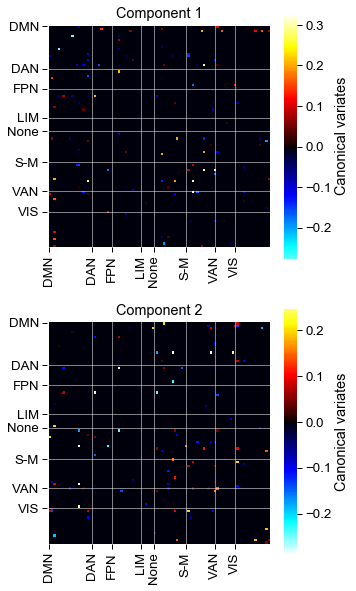

In [9]:
# plotting
fig, axarr= plt.subplots(2, 1, figsize=(5, 10))

for i, mat in enumerate(recon):
    mat, ticks, ticklabels = sort_by_yeo7(mat)
    
    loc_x, loc_y = np.unravel_index(i, (2,1))
    ax_cur = axarr[loc_x]
        
    sns.heatmap(mat, center=0,
                    square=True, annot=False,
                    cbar_kws={'label': 'Canonical variates'},
                    cmap='cold_hot', ax=ax_cur)
    
    ax_cur.set_title('Component {}'.format(i + 1))

    ax_cur.hlines(ticks[1:], *ax_cur.get_xlim(), color='w', lw=0.5)
    ax_cur.vlines(ticks[1:], *ax_cur.get_ylim(), color='w', lw=0.5)

    ax_cur.set_xticks(ticks)
    ax_cur.set_xticklabels(ticklabels)
    ax_cur.set_yticks(ticks)
    ax_cur.set_yticklabels(ticklabels)

# fig.savefig('reports/figures/cca_FC_loading.png', dpi=300, transparent=True)
plt.show()
plt.close()

## Create complimentary whole brain map per component
Average all edges values

In [52]:
for c, mat in enumerate(recon):
    cur = np.zeros(cradock_label_nii.shape)
    avg_mat = mat.mean_(axis=0) / (mat!=0).astype(int).sum(axis=0)  # average canonical vector values when not 0
    mat = np.nan_to_num(avg_mat)
    for i in range(100):
        cluster = ( cradock_label_nii.get_data() == i + 1 ).astype('int') * mat[i]
        cur += cluster
    cur = nib.Nifti1Image(cur, cradock_label_nii.affine, header=cradock_label_nii.header)
    nib.save(cur, 'reports/figures/CCA/niftis/scca_mode{:}_mean.nii.gz'.format(c + 1))

/home/hw1012/research/Project_TaskSCCA/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


## positive edges only

In [53]:
for c, mat in enumerate(recon):
    cur = np.zeros(cradock_label_nii.shape)
    avg_mat = (mat * (mat > 0).astype(int)).sum(axis=0) / (mat > 0).astype(int).sum(axis=0)  # average canonical vector values when not 0
    mat = np.nan_to_num(avg_mat)
    for i in range(100):
        cluster = ( cradock_label_nii.get_data() == i + 1 ).astype('int') * mat[i]
        cur += cluster
    cur = nib.Nifti1Image(cur, cradock_label_nii.affine, header=cradock_label_nii.header)
    nib.save(cur, 'reports/figures/CCA/niftis/scca_mode{:}_positive_mean.nii.gz'.format(c + 1))

/home/hw1012/research/Project_TaskSCCA/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


## negative edges only

In [51]:
for c, mat in enumerate(recon):
    cur = np.zeros(cradock_label_nii.shape)
    avg_mat = (mat * (mat < 0).astype(int)).sum(axis=0) / (mat < 0).astype(int).sum(axis=0)  # average canonical vector values when not 0
    mat = np.nan_to_num(avg_mat)    
    for i in range(100):
        cluster = ( cradock_label_nii.get_data() == i + 1 ).astype('int') * mat[i]
        cur += cluster
    cur = nib.Nifti1Image(cur, cradock_label_nii.affine, header=cradock_label_nii.header)
    nib.save(cur, 'reports/figures/CCA/niftis/scca_mode{:}_negative_mean.nii.gz'.format(c + 1))

/home/hw1012/research/Project_TaskSCCA/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
%%bash
wb_command -volume-to-surface-mapping \
    "reports/figures/CCA/niftis/scca_mode2_positive_mean.nii.gz" \
    "reports/figures/CCA/niftis/surface_display/lh.midthickness.5k_fs_LR.surf.gii" \
    "reports/figures/CCA/niftis/surface_display/lh.scca_mode2_positive_mean.func.gii" \
    -ribbon-constrained \
    ${OUTDIR}/${HEMI}.white.MNI.surf.gii \
    ${OUTDIR}/${HEMI}.pial.MNI.surf.gii \
    -volume-roi ${TMPDIR}/goodvoxels.nii.gz
    
wb_command -volume-to-surface-mapping \
    "reports/figures/CCA/niftis/scca_mode2_positive_mean.nii.gz" \
    "reports/figures/CCA/niftis/surface_display/rh.midthickness.5k_fs_LR.surf.gii" \
    "reports/figures/CCA/niftis/surface_display/rh.scca_mode2_positive_mean.func.gii" \
    -enclosing
    
wb_command -volume-to-surface-mapping \
    "reports/figures/CCA/niftis/scca_mode2_negative_mean.nii.gz" \
    "reports/figures/CCA/niftis/surface_display/lh.midthickness.5k_fs_LR.surf.gii" \
    "reports/figures/CCA/niftis/surface_display/lh.scca_mode2_negative_mean.func.gii" \
    -enclosing
    
wb_command -volume-to-surface-mapping \
    "reports/figures/CCA/niftis/scca_mode2_negative_mean.nii.gz" \
    "reports/figures/CCA/niftis/surface_display/rh.midthickness.5k_fs_LR.surf.gii" \
    "reports/figures/CCA/niftis/surface_display/rh.scca_mode2_negative_mean.func.gii" \
    -enclosing